# Peer-graded Assignment: Эксперименты с моделью

На прошлой неделе вы поучаствовали в соревновании на kaggle и, наверняка, большинство успешно справилось с прохождением baseline, а значит пора двигаться дальше - заняться оптимизацией модели, провести серию экспериментов и построить сильное финальное решения.

В этом задании вам нужно провести ряд эскпериментов, оценить качество полученных в процессе экспериментирования моделей и выбрать лучшее решение. 

Задание будет оцениваться на основании загруженного jupyther notebook и развернутых ответов на поставленные вопросы.

In [0]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier, XGBRFRegressor
% matplotlib inline
from sklearn.model_selection import learning_curve
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_recall_curve, roc_curve, average_precision_score, roc_auc_score, roc_curve, auc, f1_score
from sklearn.preprocessing import KBinsDiscretizer, OrdinalEncoder
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import LinearSVC
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.manifold import TSNE
import gc
import time


In [2]:
import os

from google.colab import drive
drive.mount('/content/drive')

import warnings
warnings.filterwarnings('ignore')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
os.chdir('/content/drive/My Drive/churn_pred')

In [0]:
def dropUninformativeFeatures(data):
    """Drop features with one unique value"""
    cols_to_drop = []
    
    for col in data.columns:
        if len(data[col].unique()) == 1:
            cols_to_drop.append(col)
   
    if len(cols_to_drop) > 0:
        data.drop(columns=cols_to_drop, inplace=True)

def getNumCatFeats(data):
    import re
    num_f = [idx for idx, col in enumerate(data.columns) if int(re.search('\d+', col).group()) <= 190]
    cat_f = [idx for idx, col in enumerate(data.columns) if int(re.search('\d+', col).group()) > 190]
    names_num_f = [col for col in data.columns if int(re.search('\d+', col).group()) <= 190]
    names_cat_f = [col for col in data.columns if int(re.search('\d+', col).group()) > 190]
    return num_f, cat_f, names_num_f, names_cat_f

def LabelEnc(data, cat_features):
    data1 = data.copy()
    data1 = data1.fillna(0)
    enc = LabelEncoder()
    for feat in cat_features:
        data1.loc[:, feat] = enc.fit_transform(data.loc[:, feat].astype(str))
    return data1

def OrdinalEnc(data, cat_features):
    data1 = data.copy()
    enc = OrdinalEncoder()
    data1.loc[:, cat_features] = enc.fit_transform(data[cat_features].astype(str))
    return data1

def Discretize1(data, n_bins=7):
    data1 = data.copy()
    
    #категоризация численных признаков
    num_to_cat_feats = []
    num_to_discretize = []
    for feat in data1.columns[:190]:
        if len(data1[feat].value_counts())>=100:
            num_to_discretize.append(feat)
        elif len(data1[feat].value_counts())>1:
            num_to_cat_feats.append(feat)
            
    discretizer = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='quantile')
    data1.loc[:, num_to_discretize] = discretizer.fit_transform(data[num_to_discretize])
    
    # определение категориальных, численных признаков
    num_f, cat_f, names_numf, names_cat_f = getNumCatFeats(data1)
    
    #кодирование категориальных признаков
    data1 = LabelEnc(data1, num_to_cat_feats + names_cat_f)
    
    # отбросим неинфомативные признаки
    dropUninformativeFeatures(data1)
    
    return data1

def Discretize2(data, n_bins=7):    
    #категоризация численных признаков
    num_to_cat_feats = []
    num_to_discretize = []
    for feat in data.columns[:190]:
        if len(data[feat].value_counts())>=100:
            num_to_discretize.append(feat)
        elif len(data[feat].value_counts())>1:
            num_to_cat_feats.append(feat)
            
    discretizer = KBinsDiscretizer(n_bins=n_bins, encode='onehot', strategy='quantile')
    one_hot_data = discretizer.fit_transform(data[num_to_discretize])
    one_hot_data = one_hot_data.toarray()
    
    # определение категориальных, численных признаков
    num_f, cat_f, names_numf, names_cat_f = getNumCatFeats(data)
    
    #кодирование категориальных признаков
    data1 = LabelEnc(data[num_to_cat_feats + names_cat_f], num_to_cat_feats + names_cat_f)
    
    #объединение
    one_hot_data = pd.DataFrame(one_hot_data, columns=['new_Var_'+str(i+1) for i in range(one_hot_data.shape[1])])
    data1 = pd.concat((data1, one_hot_data), axis=1, ignore_index=True)
    
    # отбросим неинфомативные признаки
    dropUninformativeFeatures(data1)
    
    return data1
        
#кросс-валидация
def KFold(estimator, data, target, weights, n_folds = 5):
    scf = StratifiedKFold(n_splits = n_folds)
    y_scores = pd.DataFrame()
    y_tests = pd.DataFrame()
    fold = 1
    for train_index, test_index in scf.split(data, target):
        estimator.fit(data.iloc[train_index, :], target.iloc[train_index], sample_weight = weights)
        y_scores['Fold_' + str(fold)] = pd.Series(estimator.predict_proba(data.iloc[test_index, :])[:,1])
        y_tests['Fold_' + str(fold)] = pd.Series(target.iloc[test_index].values.flatten())
        fold = fold + 1
    return y_scores, y_tests

def ROCCurve(y_true, y_probas):
    plt.figure(figsize=(10,10))
    linewidth = 2
    n = 1
    mean_roc = []
    # для каждого фолда
    for i,j in zip(y_true, y_probas):
        fpr, tpr, thresholds = roc_curve(y_true[i].dropna(),y_probas[j].dropna())
        roc = round(auc(fpr,tpr),2)
        mean_roc.append(roc)
        plt.plot(fpr, tpr, color='g', label='ROC Fold '+str(n)+ f' Area = {roc}', lw=linewidth)
        n += 1
    plt.plot([0, 1], [0, 1], color='b', lw=linewidth, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.xlim([0.0, 1.1])
    plt.ylim([0.0, 1.1])
    plt.legend(loc="lower right")
    mean_roc = np.array(mean_roc)
    plt.title(f'ROC curve: Mean ROC={round(mean_roc.mean(), 2)}')
    plt.show()
    
#undersampling
def undersampling(data, target, balance):
    """balance - share of class 1, balance >= 1"""
    data1 = pd.concat([data, target], axis=1, ignore_index=True)
    dataChurn = data1[target.values == 1]
    dataNoChurn = data1[target.values == -1]
    countFirst = len(dataChurn) * balance if len(dataChurn) * balance<= len(dataNoChurn) else len(dataNoChurn)
    dataChurn = dataChurn.append(dataNoChurn.iloc[:countFirst,:], ignore_index=True)
    dataChurn = shuffle(dataChurn)
    return dataChurn.iloc[:,:-1], dataChurn.iloc[:,-1]

def importOfFeats(data, estimator):
    """Return importance of features calculated by the estimator"""
    df = pd.DataFrame(data=estimator.feature_importances_, columns=['feature_importances'])
    df['feature'] = data.columns.values
    df.sort_values("feature_importances", inplace=True, ascending=False)

    
    fig = plt.figure(figsize=(25, 65))
    ax = fig.add_subplot(111)
    
    plt.barh(np.arange(df.shape[0]), df.feature_importances.values, color='g')
    plt.yticks(np.arange(df.shape[0]), df["feature"])
    plt.show()
    
    return df

## Инструкции

1\. Начнем с простого. Давайте оценим как много объектов действительно нужно для построения качественной модели. Для обучения доступна достаточно большая выборка и может так оказаться, что начиная с некоторого момента рост размера обучающей выборки перестает влиять на качество модели. Постройте кривые обучения, обучая модель на выборках разного размера начиная с небольшого количество объектов в обучающей выборке и постепенно наращивая её размер с некоторым шагом. Обратите внимание на `sklearn.model_selection.learning_curve`

In [5]:
#загрузка данных
train = pd.read_csv('Train_full.csv', sep =',')
labels = pd.DataFrame(train['labels'])
train = train.drop(columns=['labels'])

print(train.shape, labels.shape)

(40000, 230) (40000, 1)


In [0]:
# заполнение пропусков нулями
train = train.fillna(0)

# отбросим неинфомативные признаки
dropUninformativeFeatures(train)

# определение категориальных, численных признаков

def getNumCatFeats(data):
    import re
    num_f = [idx for idx, col in enumerate(data.columns) if int(re.search('\d+', col).group()) <= 190]
    cat_f = [idx for idx, col in enumerate(data.columns) if int(re.search('\d+', col).group()) > 190]
    names_num_f = [col for col in data.columns if int(re.search('\d+', col).group()) <= 190]
    names_cat_f = [col for col in data.columns if int(re.search('\d+', col).group()) > 190]
    return num_f, cat_f, names_num_f, names_cat_f

num_f, cat_f, names_numf, names_cat_f = getNumCatFeats(train)

#кодирование категориальных признаков
enc_data = LabelEnc(train, names_cat_f)

In [0]:
estimator = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=3)

In [0]:
train_sizes_abs, train_scores, test_scores = learning_curve(estimator, enc_data, labels, groups=None, 
                                                             train_sizes=np.linspace(0.1, 1, 10), 
                                                             cv=5, scoring='roc_auc', random_state=100)

In [0]:
#Отображение кривых обучения
def plot_learning_curve(title, train_sizes, train_scores, test_scores):
    plt.figure(figsize=(20,10))
    plt.title(title)
    
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    
    plt.legend(loc="best")
    return plt

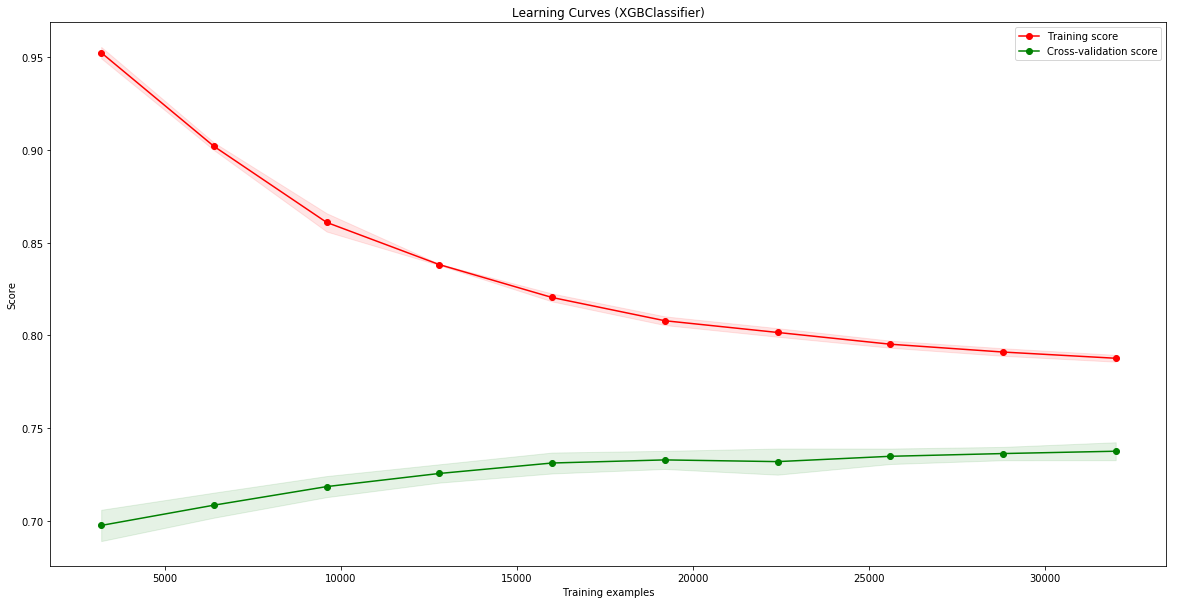

In [10]:
title = "Learning Curves (XGBClassifier)"
plot_learning_curve(title, train_sizes_abs, train_scores, test_scores)
plt.show()

Примерно с размера тренировочного набора в 16000 качество на кросс-валидации перестаёт значительно увеличиваться.

2\. Часто несбалансированные по классам выборки приводят к различным проблемам при обучении моделей. Давайте попробуем по-разному обработать выборку, поиграть с распределением объектов по классам и сделать выводы о том, как соотношение классов влияет на качество модели.

2.1\. Задайте веса объектам так, чтобы соотношение классов с учетом весов объектов изменилось. Попробуйте не менее трёх различных вариантов весов. Меняются ли результаты классификации? Как это сказывается на качестве модели? Какой вариант выглядит наиболее оптимальным с точки зрения качества?

In [11]:
#соотношение классов
labels['labels'].value_counts() / labels.shape[0] * 100

-1    92.56
 1     7.44
Name: labels, dtype: float64

Веса классов класс отток 1.3  / класс не отток 0.7


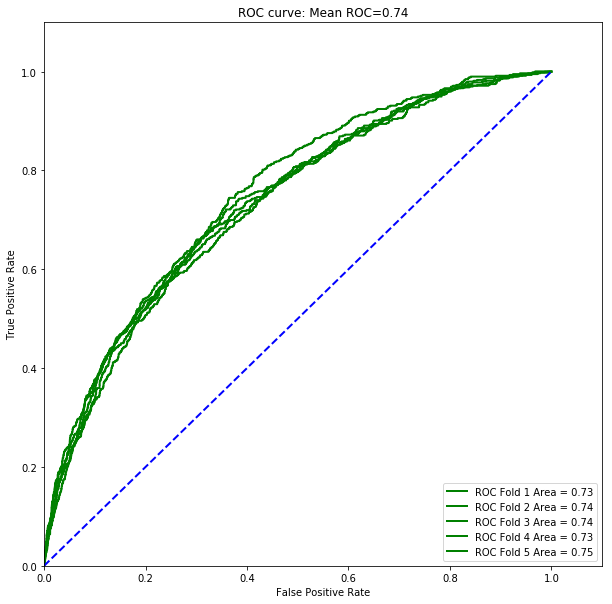

In [12]:
weights = {1: 1.3, -1: 0.7}
print('Веса классов', f'класс отток {weights[1]}  /', f'класс не отток {weights[-1]}')
weights_for_model = np.array([weights[i] for i in labels.values.flatten()])

estimator = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=3)
y_scores, y_tests = KFold(estimator, enc_data, labels, weights_for_model, n_folds = 5)
ROCCurve(y_tests, y_scores)

Веса классов класс отток 1.5  / класс не отток 1.0


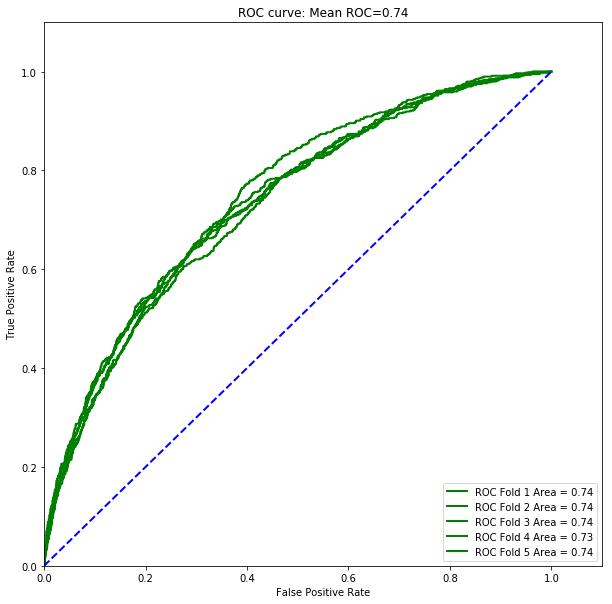

In [13]:
weights = {1: 1.5, -1: 1.0}
print('Веса классов', f'класс отток {weights[1]}  /', f'класс не отток {weights[-1]}')
weights_for_model = np.array([weights[i] for i in labels.values.flatten()])

estimator = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=3)
y_scores, y_tests = KFold(estimator, enc_data, labels, weights_for_model, n_folds = 5)
ROCCurve(y_tests, y_scores)

Веса объектов класс отток 1.0  / класс не отток 1.0


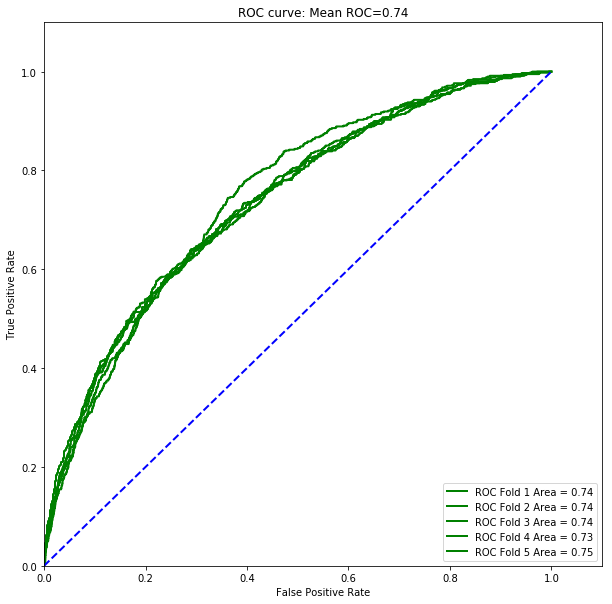

In [14]:
weights = {1: 1.0, -1: 1.0}
print('Веса объектов', f'класс отток {weights[1]}  /', f'класс не отток {weights[-1]}')
weights_for_model = np.array([weights[i] for i in labels.values.flatten()])

estimator = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=3)
y_scores, y_tests = KFold(estimator, enc_data, labels, weights_for_model, n_folds = 5)
ROCCurve(y_tests, y_scores)

Манипуляции с весами несущественно влияют на качество работы моделей. лучший результат показала модель с параметрами весов 1:1.

2.2\. Примените к выборке технологию undersampling: для этого нужно убрать из обучения некоторое количество объектов большего класса таким образом, чтобы соотношение классов изменилось. Попробуйте не менее трёх различных вариантов undersampling (варианты могут отличаться как по количество отфильтрованных объектов, так и по принципу выборка объектов для отсеивания из выборки). Меняются ли результаты классификации? Как это сказывается на качестве модели? Какой вариант выглядит наиболее оптимальным с точки зрения качества?

Веса объектов класс отток 1.0  / класс не отток 1.0


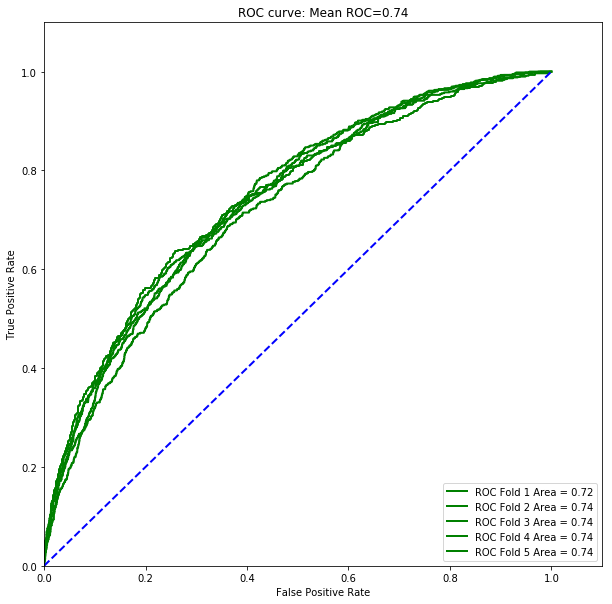

In [15]:
#undersampling, отношение количества объектов класса не отток к количеству объектов класса не отток = 10
data, target = undersampling(enc_data, labels, 10)
weights = {1: 1.0, -1: 1.0}
print('Веса объектов', f'класс отток {weights[1]}  /', f'класс не отток {weights[-1]}')
weights_for_model = np.array([weights[i] for i in labels.values.flatten()])

estimator = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=3)
y_scores, y_tests = KFold(estimator, data, target, weights_for_model, n_folds = 5)
ROCCurve(y_tests, y_scores)

Веса объектов класс отток 1.0  / класс не отток 1.0


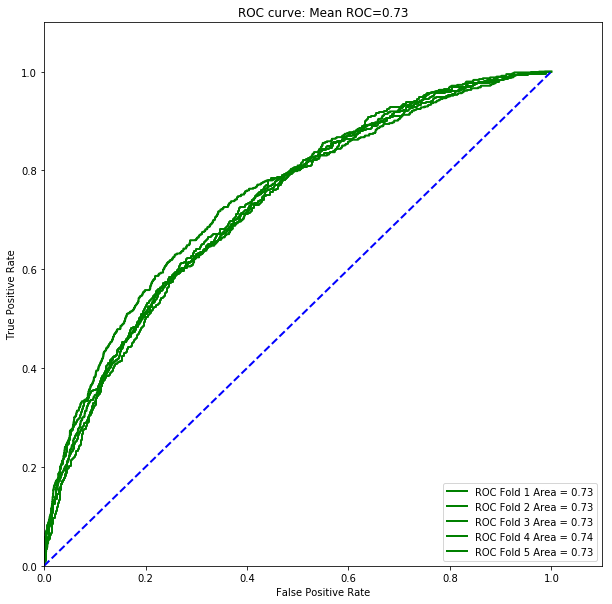

In [16]:
#undersampling, отношение количества объектов класса не отток к количеству объектов класса не отток = 7
data, target = undersampling(enc_data, labels, 7)
weights = {1: 1.0, -1: 1.0}
print('Веса объектов', f'класс отток {weights[1]}  /', f'класс не отток {weights[-1]}')
weights_for_model = np.array([weights[i] for i in labels.values.flatten()])

estimator = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=3)
y_scores, y_tests = KFold(estimator, data, target, weights_for_model, n_folds = 5)
ROCCurve(y_tests, y_scores)

Веса объектов класс отток 1.0  / класс не отток 1.0


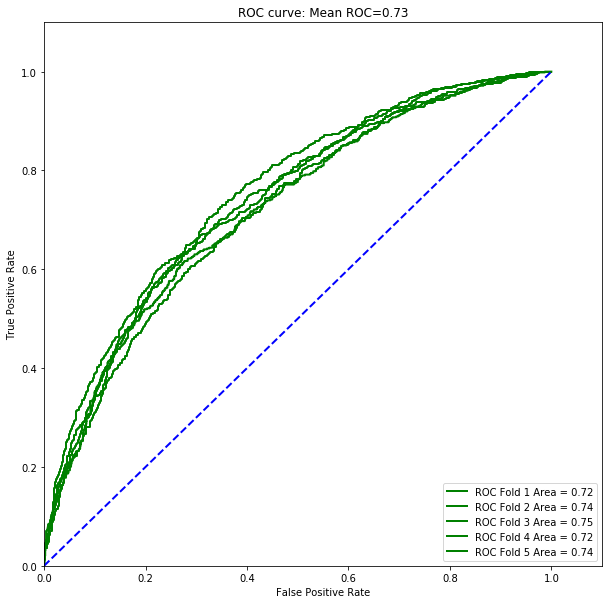

In [17]:
#undersampling, отношение количества объектов класса не отток к классу отток = 3
data, target = undersampling(enc_data, labels, 3)
weights = {1: 1.0, -1: 1.0}
print('Веса объектов', f'класс отток {weights[1]}  /', f'класс не отток {weights[-1]}')
weights_for_model = np.array([weights[i] for i in labels.values.flatten()])

estimator = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=3)
y_scores, y_tests = KFold(estimator, data, target, weights_for_model, n_folds = 5)
ROCCurve(y_tests, y_scores)

Веса объектов класс отток 1.0  / класс не отток 1.0


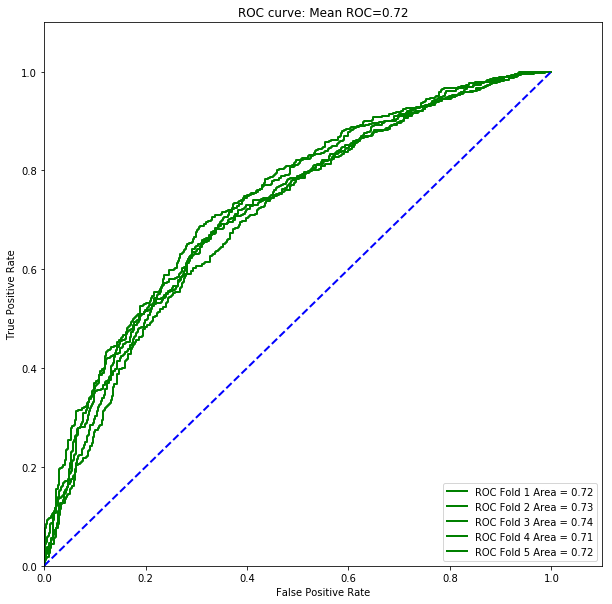

In [18]:
#undersampling, отношение количества объектов класса не отток к классу отток = 1
data, target = undersampling(enc_data, labels, 1)
weights = {1: 1.0, -1: 1.0}
print('Веса объектов', f'класс отток {weights[1]}  /', f'класс не отток {weights[-1]}')
weights_for_model = np.array([weights[i] for i in labels.values.flatten()])

estimator = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=3)
y_scores, y_tests = KFold(estimator, data, target, weights_for_model, n_folds = 5)
ROCCurve(y_tests, y_scores)

Веса объектов класс отток 1.0  / класс не отток 1.0


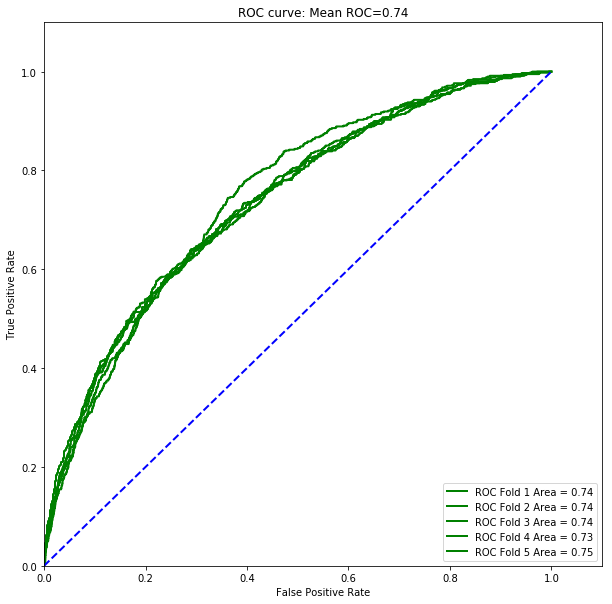

In [19]:
#без использования undersampling, сохраняется исходное соотношение классов
weights = {1: 1.0, -1: 1.0}
print('Веса объектов', f'класс отток {weights[1]}  /', f'класс не отток {weights[-1]}')
weights_for_model = np.array([weights[i] for i in labels.values.flatten()])

estimator = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=3)
y_scores, y_tests = KFold(estimator, enc_data, labels, weights_for_model, n_folds = 5)
ROCCurve(y_tests, y_scores)

В дальнейшем будет использоваться исходное соотношение классов в датасете, то есть все объекты в выборке.

3\. Теперь перейдем к работе с признаками. Ранее вы реализовали несколько стратегий для обработки пропущенных значений. Сравните эти стратегии между собой с помощью оценки качества моделей кросс-валидации, построенных на датасетах с использованием различных стратегий. Как обработка пропущенных значений сказывается на качестве модели? Какой вариант выглядит наиболее оптимальным с точки зрения качества?

In [20]:
#загрузка данных
train = pd.read_csv('Train_full.csv', sep =',')
labels = pd.DataFrame(train['labels'])
train = train.drop(columns=['labels'])

print(train.shape, labels.shape)

(40000, 230) (40000, 1)


Заполнение пропусков в численных признаках нулями, в категориальных - наиболее часто встречающимися значениями.

In [0]:
train_1 = train.copy()

# заполнение пропусков в численных признаках нулями
train_1.iloc[:, :190] = train_1.iloc[:, :190].fillna(0)

# заполнение пропусков в категориальных признаках самым частым значением
for i in range(190,230):
    if len(train_1.iloc[:,i].value_counts())>0:
        most = train_1.iloc[:,i].value_counts().index[0]
        train_1.iloc[:,i] = train_1.iloc[:,i].fillna(most)
    else:
        train_1.iloc[:,i] = train_1.iloc[:,i].fillna(0)

# отбросим неинфомативные признаки
dropUninformativeFeatures(train_1)
        
# определение категориальных, численных признаков
num_f, cat_f, names_num_f, names_cat_f = getNumCatFeats(train_1)

#кодирование категориальных признаков
enc_data_1 = LabelEnc(train_1, names_cat_f)

Веса объектов класс отток 1.0  / класс не отток 1.0


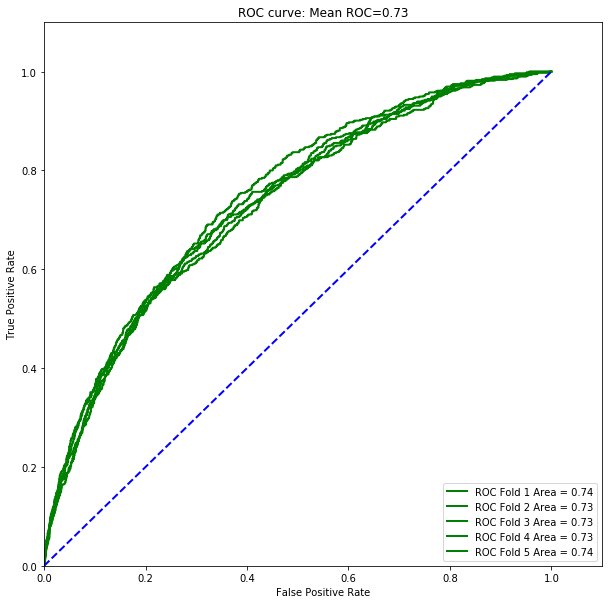

In [22]:
weights = {1: 1.0, -1: 1.0}
print('Веса объектов', f'класс отток {weights[1]}  /', f'класс не отток {weights[-1]}')
weights_for_model = np.array([weights[i] for i in labels.values.flatten()])

estimator = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=3)
y_scores, y_tests = KFold(estimator, enc_data_1, labels, weights_for_model, n_folds = 5)
ROCCurve(y_tests, y_scores)

Заполнение пропусков в численных признаках медианными значениями, в категориальных - наиболее часто встречающимися значениями.

In [0]:
train_2 = train.copy()

# заполнение пропусков в численных признаках медианными значениями
scaler = StandardScaler()
X_num = train_2[train_2.columns[:190]]
X_num = pd.DataFrame(scaler.fit_transform( X_num.values), index=X_num.index, columns=X_num.columns)
X_num = X_num.fillna(X_num.median(axis=0))

#train_2.loc[:, names_num_f] = train_2[names_num_f].fillna(train[names_num_f].median(axis=0))

# заполнение пропусков в категориальных признаках самым частым значением
for feat in train_2.columns[190:]:
    if len(train_2[feat].value_counts())>0:
        train_2.loc[:, feat] = train_2[feat].fillna(value=train_2[feat].value_counts().index[0])
    else:
        train_2.loc[:, feat] = train_2[feat].fillna(0)

train_2.iloc[:, :190] = X_num
    
# отбросим неинфомативные признаки
dropUninformativeFeatures(train_2)

# определение категориальных, численных признаков
num_f, cat_f, names_num_f, names_cat_f = getNumCatFeats(train_2)    

#кодирование категориальных признаков
enc_data_2 = LabelEnc(train_2, names_cat_f)

Веса объектов класс отток 1.0  / класс не отток 1.0


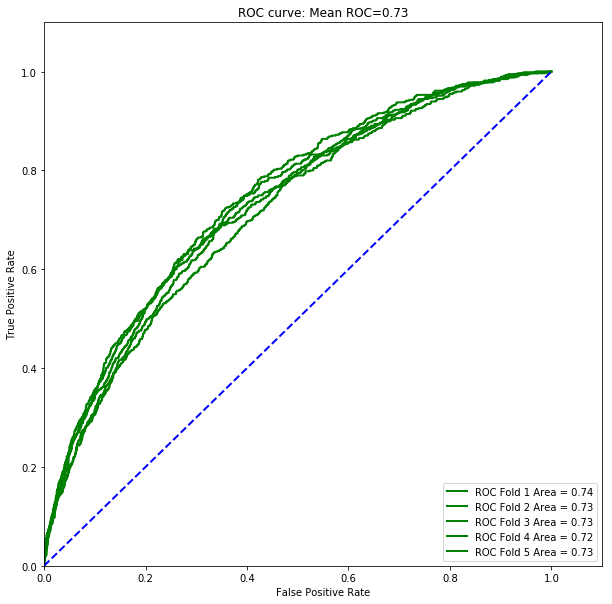

In [24]:
weights = {1: 1.0, -1: 1.0}
print('Веса объектов', f'класс отток {weights[1]}  /', f'класс не отток {weights[-1]}')
weights_for_model = np.array([weights[i] for i in labels.values.flatten()])

estimator = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=3)
y_scores, y_tests = KFold(estimator, enc_data_2, labels, weights_for_model, n_folds = 5)
ROCCurve(y_tests, y_scores)

Заполнение пропусков в численных признаках средними значениями, в категориальных - наиболее часто встречающимися значениями.

In [0]:
train_3 = train.copy()

# заполнение пропусков в численных признаках медианными значениями
train_3.loc[:, names_num_f] = train_3[names_num_f].fillna(train[names_num_f].mean(axis=0))

# заполнение пропусков в категориальных признаках самым частым значением
for feat in names_cat_f:    
    train_3.loc[:, feat] = train_3[feat].fillna(value=train_3[feat].value_counts().index[0])
    
# отбросим неинфомативные признаки
dropUninformativeFeatures(train_3)

# определение категориальных, численных признаков
num_f, cat_f, names_num_f, names_cat_f = getNumCatFeats(train_3)

#кодирование категориальных признаков
enc_data_3 = LabelEnc(train_3, names_cat_f)

Веса объектов класс отток 1.0  / класс не отток 1.0


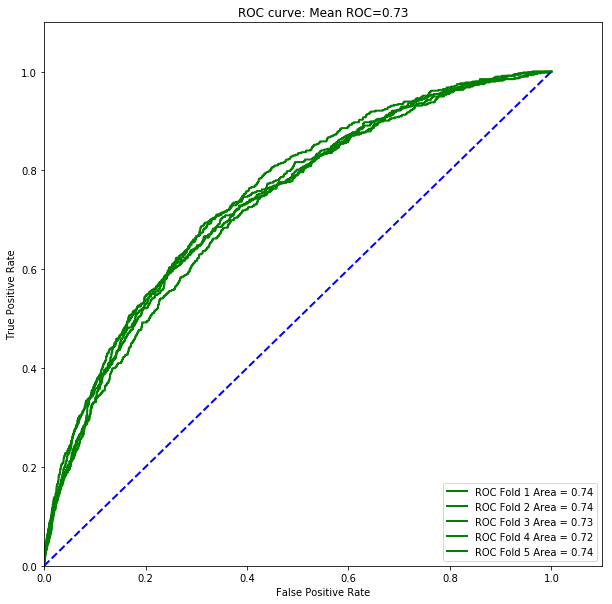

In [26]:
weights = {1: 1.0, -1: 1.0}
print('Веса объектов', f'класс отток {weights[1]}  /', f'класс не отток {weights[-1]}')
weights_for_model = np.array([weights[i] for i in labels.values.flatten()])

estimator = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=3)
y_scores, y_tests = KFold(estimator, enc_data_3, labels, weights_for_model, n_folds = 5)
ROCCurve(y_tests, y_scores)

Замена пропусков наиболее часто встречающимся значением в признаке.

In [0]:
train_4 = train.copy()

# отбросим неинфомативные признаки
dropUninformativeFeatures(train_4)

# заполнение пропусков
for feat in train_4.columns:    
    train_4.loc[:, feat] = train_4[feat].fillna(value=train_4[feat].value_counts().index[0])

# определение категориальных, численных признаков
num_f, cat_f, names_num_f, names_cat_f = getNumCatFeats(train_4)

#кодирование категориальных признаков
enc_data_4 = LabelEnc(train_4, names_cat_f)

Веса объектов класс отток 1.0  / класс не отток 1.0


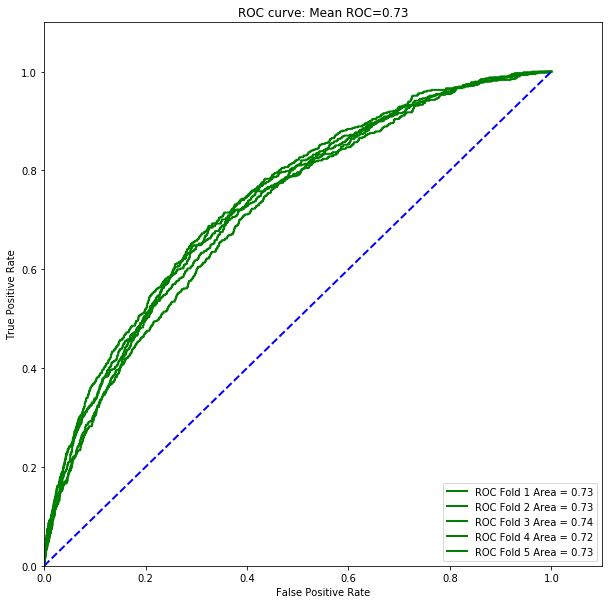

In [28]:
weights = {1: 1.0, -1: 1.0}
print('Веса объектов', f'класс отток {weights[1]}  /', f'класс не отток {weights[-1]}')
weights_for_model = np.array([weights[i] for i in labels.values.flatten()])

estimator = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=3)
y_scores, y_tests = KFold(estimator, enc_data_4, labels, weights_for_model, n_folds = 5)
ROCCurve(y_tests, y_scores)

Замена пропусков в числовых признаках средним, если количество уникальных значений больше 180, иначе наиболее часто встречающимся значением в признаке.
В категориальных - замена наиболее часто встречающимся значением в признаке.

In [0]:
train_5 = train.copy()

# заполнение пропусков в численных признаках медианными значениями
for feat in train_5.columns[:190]:
    if len(train_5[feat].value_counts())>0:
        if len(train_5[feat].value_counts()) > 180:
            train_5.loc[:, feat] = train_5.loc[:,feat].fillna(train_5[feat].mean())
        else:
            train_5.loc[:, feat] = train_5.loc[:,feat].fillna(train_5[feat].value_counts().index[0])
    else:
        train_5.loc[:, feat] = train_5.loc[:,feat].fillna(0)
        
# заполнение пропусков в категориальных признаках самым частым значением
for feat in train_5.columns[190:]:
    if len(train_5[feat].value_counts()) > 0:
        train_5.loc[:, feat] = train_5.loc[:, feat].fillna(train_5[feat].value_counts().index[0])
    else:
        train_5.loc[:, feat] = train_5.loc[:, feat].fillna(0)
    
# отбросим неинфомативные признаки
dropUninformativeFeatures(train_5)

# определение категориальных, численных признаков
num_f, cat_f, names_num_f, names_cat_f = getNumCatFeats(train_5)

#кодирование категориальных признаков
enc_data_5 = LabelEnc(train_5, names_cat_f)

Веса объектов класс отток 1.0  / класс не отток 1.0


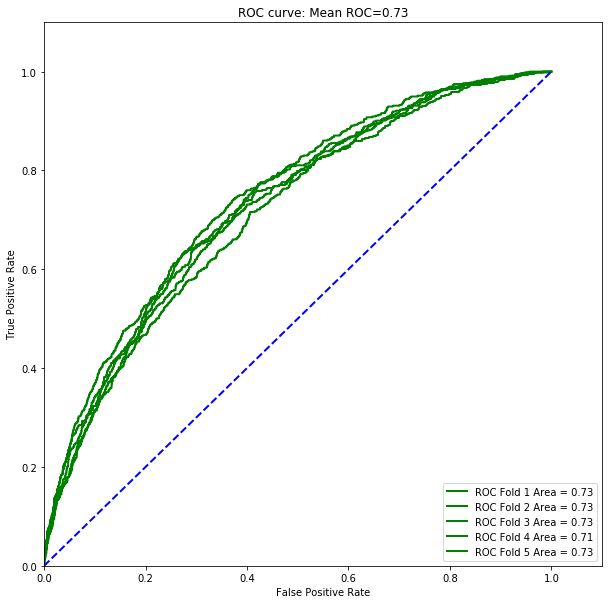

In [30]:
weights = {1: 1.0, -1: 1.0}
print('Веса объектов', f'класс отток {weights[1]}  /', f'класс не отток {weights[-1]}')
weights_for_model = np.array([weights[i] for i in labels.values.flatten()])

estimator = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=3)
y_scores, y_tests = KFold(estimator, enc_data_5, labels, weights_for_model, n_folds = 5)
ROCCurve(y_tests, y_scores)

Заполнение пропусков нулями.

In [0]:
train_6 = train.copy()

# заполнение пропусков нулями
train_6 = train_6.fillna(0)

# отбросим неинфомативные признаки
dropUninformativeFeatures(train_6)

# определение категориальных, численных признаков
num_f, cat_f, names_numf, names_cat_f = getNumCatFeats(train_6)

#кодирование категориальных признаков
enc_data_6 = LabelEnc(train_6, names_cat_f)

Веса объектов класс отток 1.0  / класс не отток 1.0


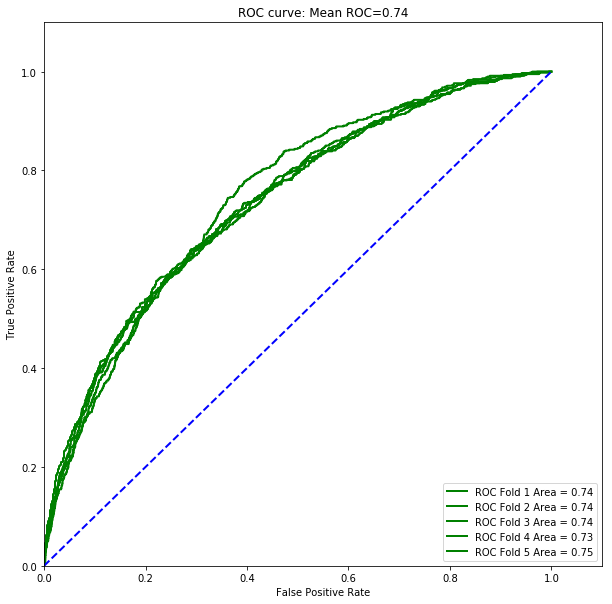

In [32]:
weights = {1: 1.0, -1: 1.0}
print('Веса объектов', f'класс отток {weights[1]}  /', f'класс не отток {weights[-1]}')
weights_for_model = np.array([weights[i] for i in labels.values.flatten()])

estimator = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=3)
y_scores, y_tests = KFold(estimator, enc_data_6, labels, weights_for_model, n_folds = 5)
ROCCurve(y_tests, y_scores)

In [33]:
del train_1
del train_2
del train_3
del train_4
del train_5
del train_6
del enc_data_1
del enc_data_2
del enc_data_3
del enc_data_4
del enc_data_5
del enc_data_6
gc.collect()

14890

Вариант с заполнением всех пропущеных значений нулями выглядит наиболее оптимальным с точки зрения качества.

4\. Также вы уже реализовали несколько стратегий для обработки категориальных признаков. Сравните эти стратегии между собой с помощью оценки качества моделей по кросс-валидации, построенных на датасетах с использованием различных стратегий. Как обработка категориальных признаков сказывается на качестве модели? Какой вариант выглядит наиболее оптимальным с точки зрения качества?

Обработка категориальных признаков с помощью OrdinalEncoder.

In [0]:
train_1 = train.copy()

# заполнение пропусков нулями
train_1 = train_1.fillna(0)

# отбросим неинфомативные признаки
dropUninformativeFeatures(train_1)

# определение категориальных, численных признаков
num_f, cat_f, names_numf, names_cat_f = getNumCatFeats(train_1)

#кодирование категориальных признаков
enc_data_1 = OrdinalEnc(train_1, names_cat_f)

Веса объектов класс отток 1.0  / класс не отток 1.0


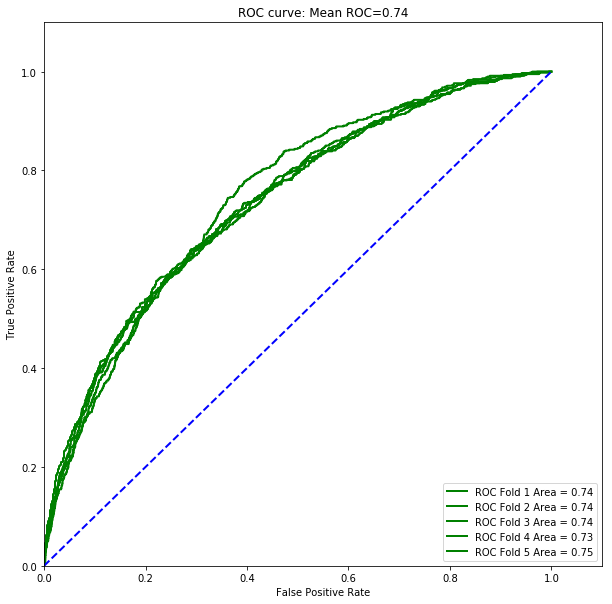

In [35]:
weights = {1: 1.0, -1: 1.0}
print('Веса объектов', f'класс отток {weights[1]}  /', f'класс не отток {weights[-1]}')
weights_for_model = np.array([weights[i] for i in labels.values.flatten()])

estimator = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=3)
y_scores, y_tests = KFold(estimator, enc_data_1, labels, weights_for_model, n_folds = 5)
ROCCurve(y_tests, y_scores)

Обработка категориальных признаков с помощью LabelEncoder.

In [0]:
train_2 = train.copy()

# заполнение пропусков нулями
train_2 = train_2.fillna(0)

# отбросим неинфомативные признаки
dropUninformativeFeatures(train_2)

# определение категориальных, численных признаков
num_f, cat_f, names_numf, names_cat_f = getNumCatFeats(train_2)

#кодирование категориальных признаков
enc_data_2 = LabelEnc(train_2, names_cat_f)

Веса объектов класс отток 1.0  / класс не отток 1.0


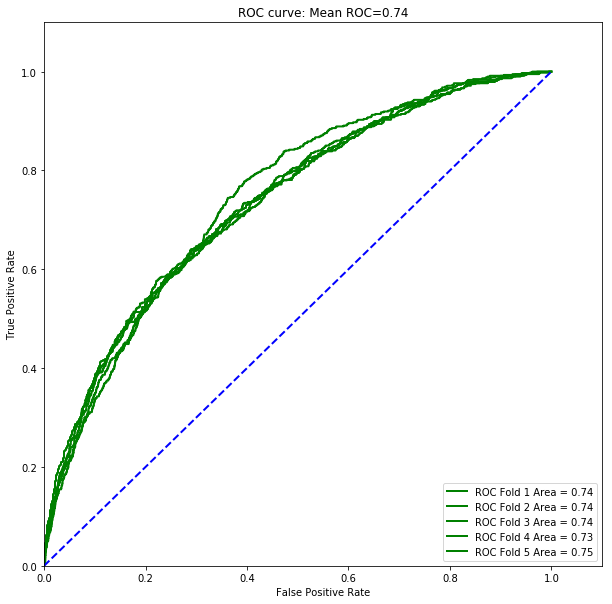

In [37]:
weights = {1: 1.0, -1: 1.0}
print('Веса объектов', f'класс отток {weights[1]}  /', f'класс не отток {weights[-1]}')
weights_for_model = np.array([weights[i] for i in labels.values.flatten()])

estimator = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=3)
y_scores, y_tests = KFold(estimator, enc_data_2, labels, weights_for_model, n_folds = 5)
ROCCurve(y_tests, y_scores)

Дискретизация численных признаков с числом уникальных значений более или равным 100, дальнейшее применение ordinalEncoding. Для численных признаков с числом уникальных значений менее 100, применение labelEncoding. labelEncoding для категориальных признаков.

In [0]:
train_3 = train.copy()

# заполнение пропусков нулями
train_3 = train_3.fillna(0)

# обработка признаков
enc_data_3 = Discretize1(train_3)

Веса объектов класс отток 1.0  / класс не отток 1.0


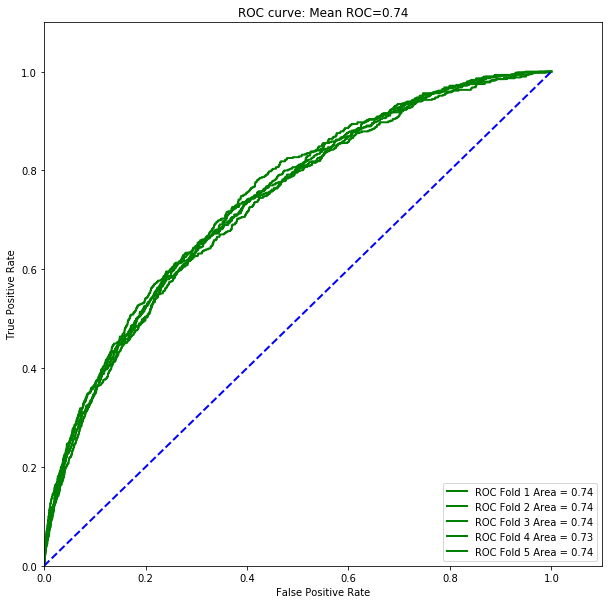

In [39]:
weights = {1: 1.0, -1: 1.0}
print('Веса объектов', f'класс отток {weights[1]}  /', f'класс не отток {weights[-1]}')
weights_for_model = np.array([weights[i] for i in labels.values.flatten()])

estimator = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=3)
y_scores, y_tests = KFold(estimator, enc_data_3, labels, weights_for_model, n_folds = 5)
ROCCurve(y_tests, y_scores)

Дискретизация численных признаков с числом уникальных значений более или равным 100, дальнейшее применение oneHotEncoding. Для численных признаков с числом уникальных значений менее 100, применение labelEncoding. labelEncoding для категориальных признаков.

In [0]:
train_4 = train.copy()

# заполнение пропусков нулями
train_4 = train_4.fillna(0)

# обработка признаков
enc_data_4 = Discretize2(train_4)

Веса объектов класс отток 1.0  / класс не отток 1.0


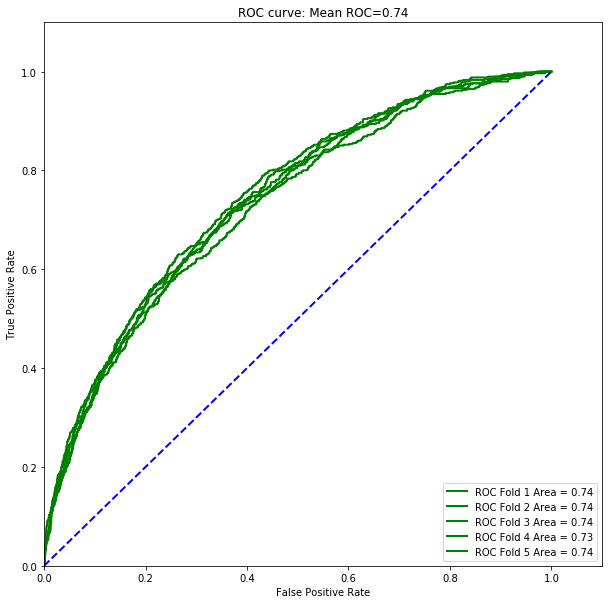

In [41]:
weights = {1: 1.0, -1: 1.0}
print('Веса объектов', f'класс отток {weights[1]}  /', f'класс не отток {weights[-1]}')
weights_for_model = np.array([weights[i] for i in labels.values.flatten()])

estimator = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=3)
y_scores, y_tests = KFold(estimator, enc_data_4, labels, weights_for_model, n_folds = 5)
ROCCurve(y_tests, y_scores)

Разные подходы не сильно повлияли на качество обучения. В дальнейшем для категориальных признаков будет использоваться labelEncoder, так как остальные подходы либо медленнее, либо повышают размерность датасета.

5\. Все ли признаки оказались полезными для построения моделей? Проведите процедуру отбора признаков, попробуйте разные варианты отбора (обратите внимание на модуль `sklearn.feature_selection`). Например, можно выбрасывать случайные признаки или строить отбор на основе l1-регуляризации - отфильтровать из обучения признаки, которые получат нулевой вес при построении регрессии с l1-регуляризацией (`sklearn.linear_model.Lasso`). И всегда можно придумать что-то своё=) Попробуйте как минимум 2 различные стратегии, сравните результаты. Помог ли отбор признаков улучшить качество модели? Поясните свой ответ.

Применение лиейного SVM для отбора признаков.

In [0]:
train_1 = train.copy()

# заполнение пропусков нулями
train_1 = train_1.fillna(0)

# отбросим неинфомативные признаки
dropUninformativeFeatures(train_1)

# определение категориальных, численных признаков
num_f, cat_f, names_numf, names_cat_f = getNumCatFeats(train_1)

#кодирование категориальных признаков
enc_data_1 = LabelEnc(train_1, names_cat_f)

In [43]:
lsvc = LinearSVC(C=0.01, penalty="l1", dual=False).fit(enc_data_1, labels)
model = SelectFromModel(lsvc, prefit=True)
enc_data_1_new = model.transform(enc_data_1)
enc_data_1_new.shape

(40000, 86)

In [0]:
enc_data_1_new = pd.DataFrame(data=enc_data_1_new, columns=[i for i in range(enc_data_1_new.shape[1])])

Веса объектов класс отток 1.0  / класс не отток 1.0


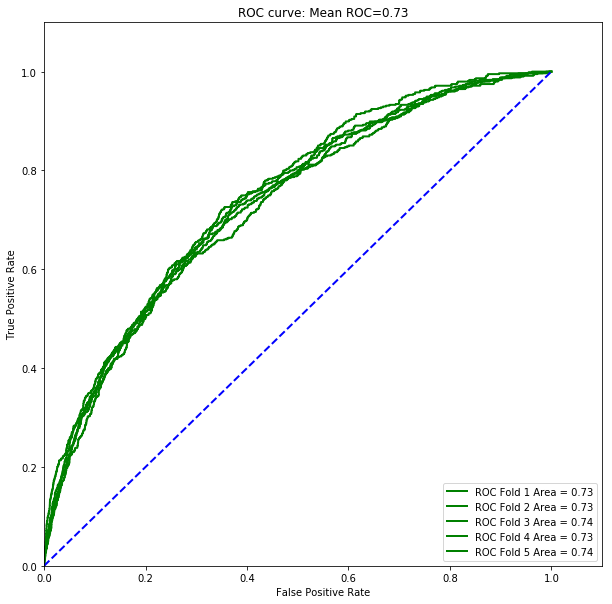

In [45]:
weights = {1: 1.0, -1: 1.0}
print('Веса объектов', f'класс отток {weights[1]}  /', f'класс не отток {weights[-1]}')
weights_for_model = np.array([weights[i] for i in labels.values.flatten()])

estimator = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=3)
y_scores, y_tests = KFold(estimator, enc_data_1_new, labels, weights_for_model, n_folds = 5)
ROCCurve(y_tests, y_scores)

Применение Lasso для отбора признаков.

In [0]:
train_2 = train.copy()

# заполнение пропусков нулями
train_2 = train_2.fillna(0)

# отбросим неинфомативные признаки
dropUninformativeFeatures(train_2)

# определение категориальных, численных признаков
num_f, cat_f, names_numf, names_cat_f = getNumCatFeats(train_2)

#кодирование категориальных признаков
enc_data_2 = LabelEnc(train_2, names_cat_f)

In [47]:
lasso = Lasso(alpha=0.01).fit(enc_data_2, labels)
model = SelectFromModel(lasso, prefit=True)
enc_data_2_new = model.transform(enc_data_2)
enc_data_2_new.shape

(40000, 35)

In [0]:
enc_data_2_new = pd.DataFrame(data=enc_data_2_new, columns=[i for i in range(enc_data_2_new.shape[1])])

Веса объектов класс отток 1.0  / класс не отток 1.0


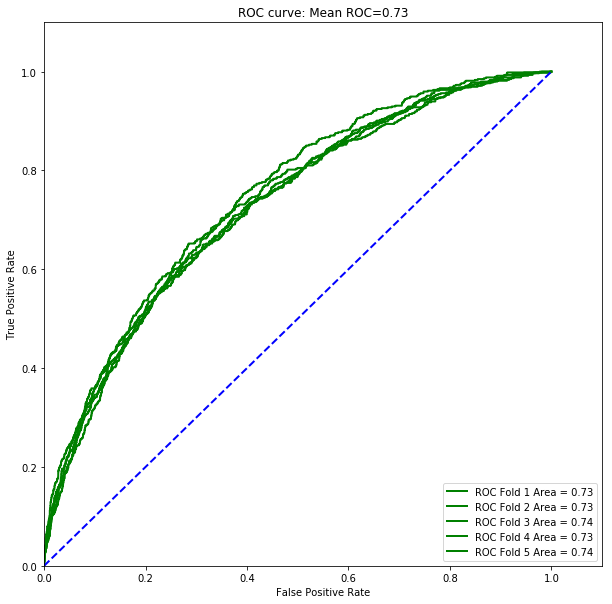

In [49]:
weights = {1: 1.0, -1: 1.0}
print('Веса объектов', f'класс отток {weights[1]}  /', f'класс не отток {weights[-1]}')
weights_for_model = np.array([weights[i] for i in labels.values.flatten()])

estimator = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=3)
y_scores, y_tests = KFold(estimator, enc_data_2_new, labels, weights_for_model, n_folds = 5)
ROCCurve(y_tests, y_scores)

Большинство признаков оказались бесполезными, качество моделей не повысилось, удалось заметно сократить размерность датасета.

6\. Подберите оптимальные параметры модели. Обратите внимание, что в зависимости от того, как вы обработали исходные данные, сделали ли балансировку классов, сколько объектов оставили в обучающей выборке и др. оптимальные значения параметров могут меняться. Возьмите наилучшее из ваших решений на текущий момент и проведите процедуру подбора параметров модели (обратите внимание на `sklearn.model_selection.GridSearchCV`) Как подбор параметров повлиял на качество модели?

* На текущий момент был определён следующий подход:
    * соотношение классов остаётся таким же, как в исходном наборе данных;
    * применяется LabeEncoder для категориальных признаков;
    * отбрасываются признаки со 100% пропусков и признаки с одним уникальным значением;
    * заполнение всех пропусков нулями.

In [0]:
parameters = {
    'n_estimators': [50, 90, 100, 150, 200],
    'max_depth': [2, 3, 4],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'min_child_weight':[1],
    'reg_lambda' : [1, 0.9],
    'reg_alpha' : [0.2, 0.4]
}

In [0]:
train_1 = train.copy()

# заполнение пропусков нулями
train_1 = train_1.fillna(0)

# отбросим неинфомативные признаки
dropUninformativeFeatures(train_1)

# определение категориальных, численных признаков
num_f, cat_f, names_numf, names_cat_f = getNumCatFeats(train_1)

#кодирование категориальных признаков
enc_data_1 = LabelEnc(train_1, names_cat_f)

In [69]:
weights = {1: 1.0, -1: 1.0}
print('Веса объектов', f'класс отток {weights[1]}  /', f'класс не отток {weights[-1]}')


estimator = XGBClassifier()
gridsearch = GridSearchCV(estimator, parameters, n_jobs=-1, scoring='roc_auc', cv=3, verbose=1)
ts = time.time()
gridsearch.fit(enc_data_1, labels)
print('Затраченное время', time.time() - ts)

Веса объектов класс отток 1.0  / класс не отток 1.0
Fitting 3 folds for each of 360 candidates, totalling 1080 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed: 28.4min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed: 77.0min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed: 150.5min
[Parallel(n_jobs=-1)]: Done 1080 out of 1080 | elapsed: 235.7min finished


Затраченное время 14171.967831611633


In [70]:
print('Лучший результат auc_roc = ', gridsearch.best_score_)
print('Лучшие параметры', gridsearch.best_params_)

Лучший результат auc_roc =  0.7379981451724077
Лучшие параметры {'colsample_bytree': 1.0, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 90, 'reg_alpha': 0.2, 'reg_lambda': 1, 'subsample': 1.0}


7\. Предложите методику оценки того, какие признаки внесли наибольший вклад в модель (например, это могут быть веса в случае регрессии, а также большое количество моделей реализуют метод `feature_importances_` - оценка важности признаков). На основе предложенной методики проанализируйте, какие признаки внесли больший вклад в модель, а какие меньший?

Для оценки важности признаков использован метод feature_importances_ модели XGBClassifier.

In [72]:
weights = {1: 1.0, -1: 1.0}
print('Веса объектов', f'класс отток {weights[1]}  /', f'класс не отток {weights[-1]}')
weights_for_model = np.array([weights[i] for i in labels.values.flatten()])

best_params = gridsearch.best_params_

best_estimator = XGBClassifier(n_estimators=best_params['n_estimators'],
                          max_depth=best_params['max_depth'],
                          subsample=best_params['subsample'],
                          colsample_bytree=best_params['colsample_bytree'],
                          min_child_weight=best_params['min_child_weight'],
                          reg_lambda=best_params['reg_lambda'],
                          reg_alpha=best_params['reg_alpha']
                         )

best_estimator.fit(enc_data_1, labels, sample_weight = weights_for_model)

Веса объектов класс отток 1.0  / класс не отток 1.0


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1.0, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=None, n_estimators=90, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0.2, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1.0, verbosity=1)

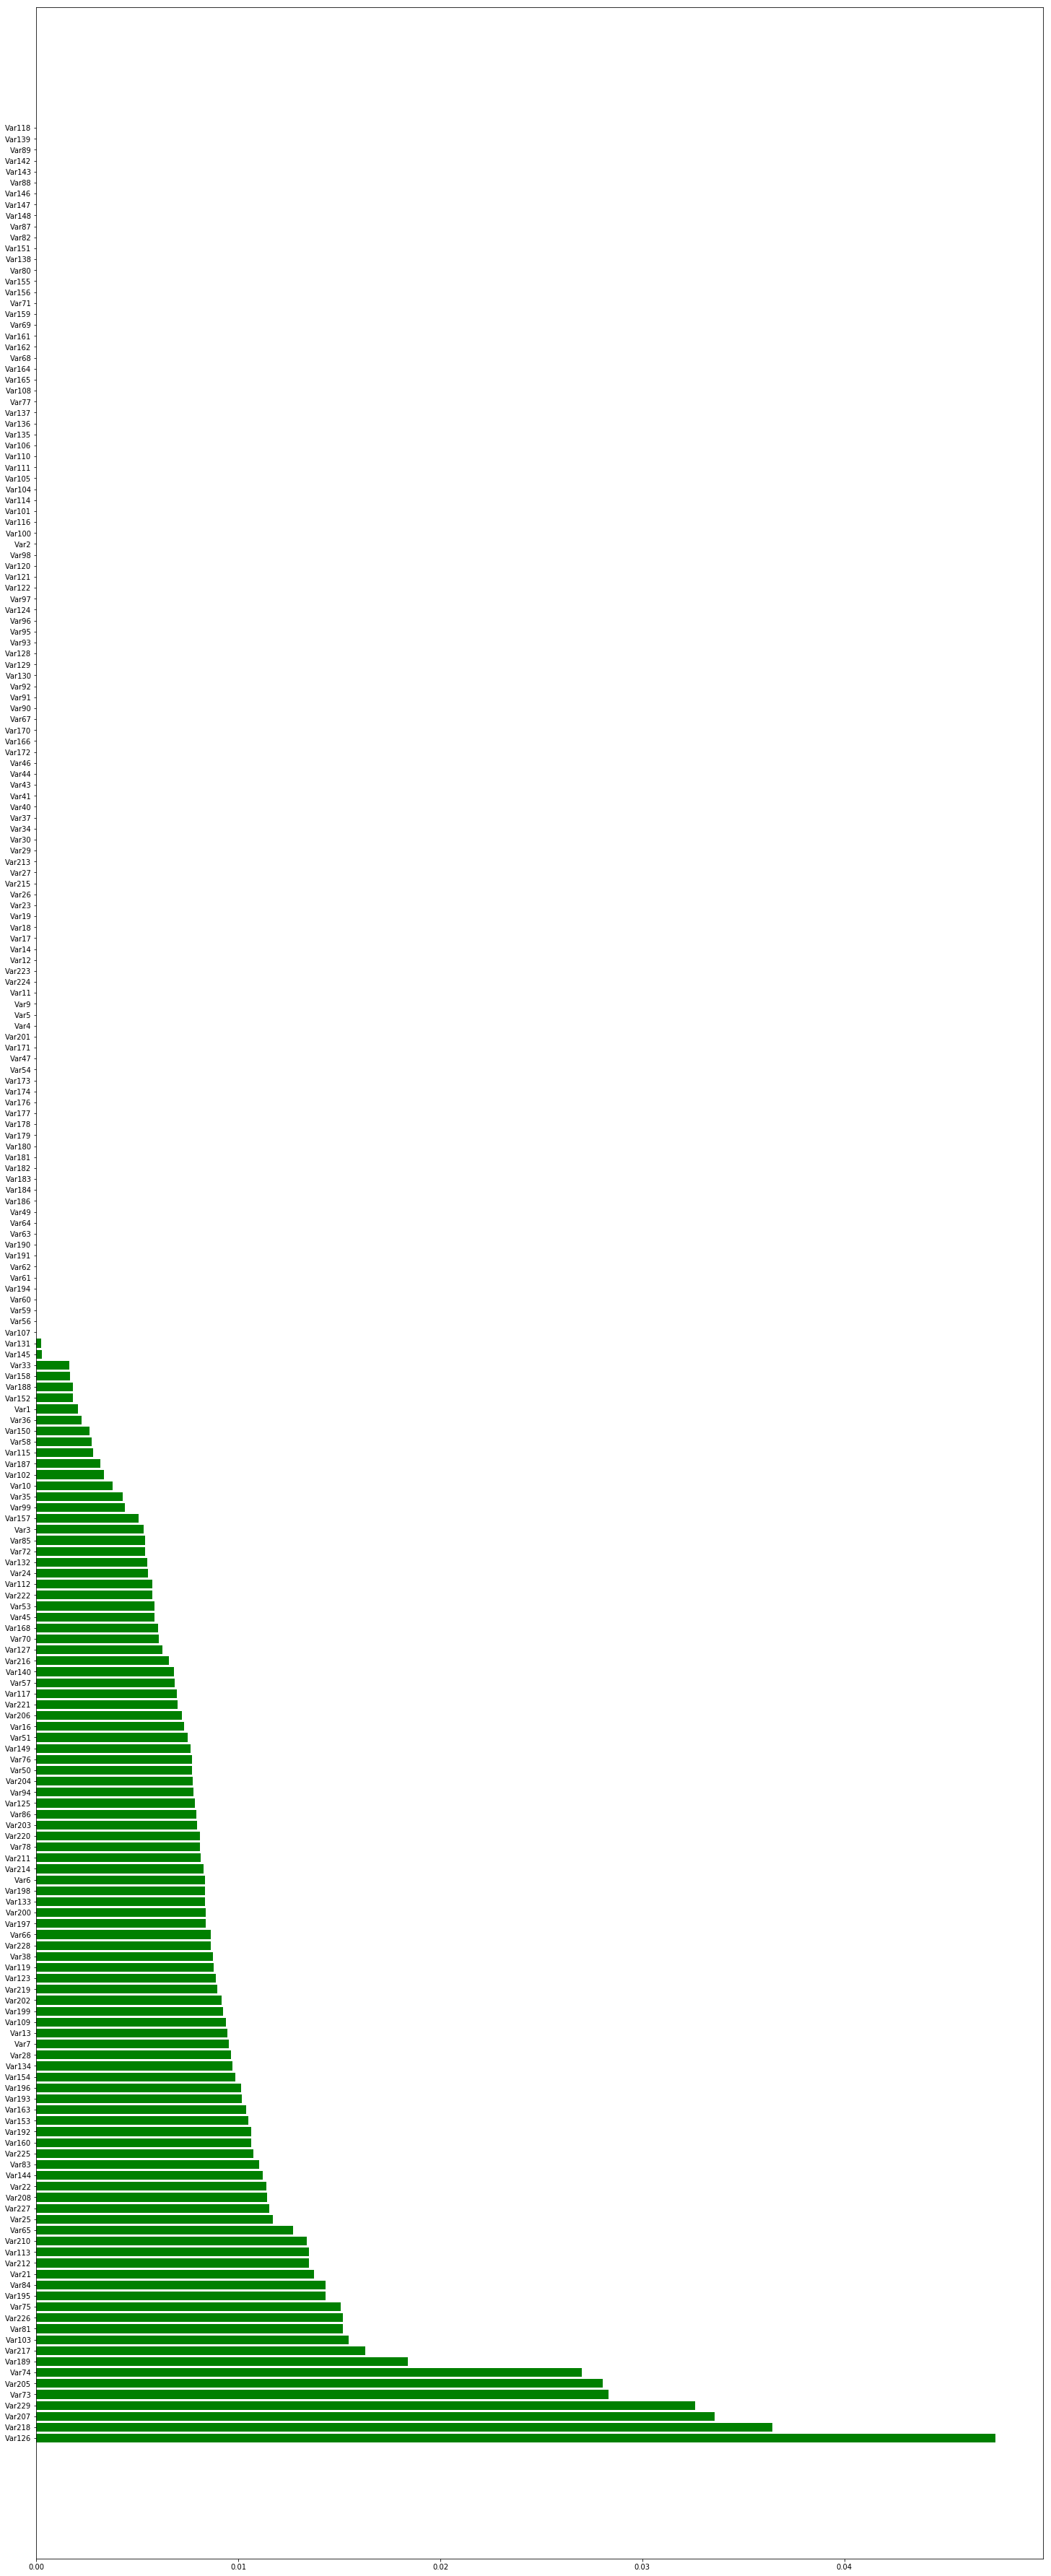

In [73]:
importances_feats = importOfFeats(enc_data_1, best_estimator)

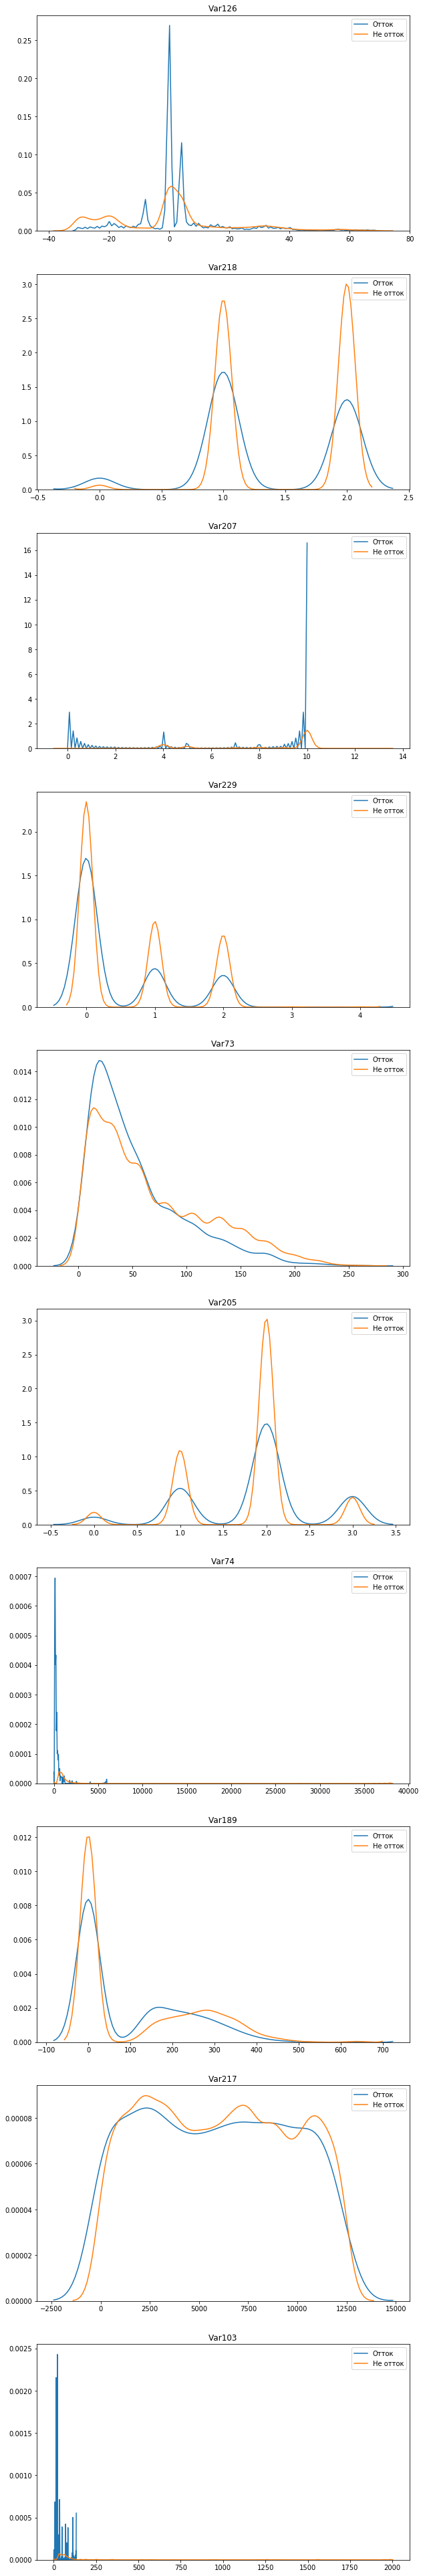

In [135]:
fig, ax = plt.subplots(nrows=10,ncols=1,figsize=(10,70))
for index, i in enumerate(importances_feats[:10].feature):
    a = sns.kdeplot(enc_data_1[(labels == 1).values][i], ax = ax[index], label = 'Отток')
    a = sns.kdeplot(enc_data_1[(labels == -1).values][i], ax = ax[index], label = 'Не отток')
    a.title.set_text(i)

По визуализации видно, что более половины признаков являются бесполезными для модели.

8\. Напоследок давайте посмотрим на объекты. На каких объектах достигается наибольшая ошибка классификации? Есть ли межу этими объектами что-то общее? Видны ли какие-либо закономерности? Предположите, почему наибольшая ошибка достигается именно на этих объектах. В данном случае "наибольшую" ошибку можно понимать как отнесение объекта с чужому классу с большой долей уверенности (с высокой вероятностью).

In [0]:
predicted = best_estimator.predict(enc_data_1)
predicted_proba = best_estimator.predict_proba(enc_data_1)[:, 0]

In [0]:
def seachObjsError(data, labels, predicted, predicted_proba, thresh_1, thresh_2):
    first_type_err =[]
    second_type_err = []
    
    for sample in range(len(data)):
        if (labels.iloc[sample,0] == 1.0) and (predicted[sample] == -1.0):
            if abs(1-predicted_proba[sample]) > thresh_1:
                first_type_err.append(sample)
        if (labels.iloc[sample,0] == -1.0) and (predicted[sample] == 1.0):
            if abs(predicted_proba[sample]) > thresh_2:
                second_type_err.append(sample)
                
    print('Количество ошибок первого рода: ' + str(len(first_type_err)))
    print('Количество ошибок второго рода: ' + str(len(second_type_err)))
    return(first_type_err, second_type_err)

In [111]:
first_type_err, second_type_err = seachObjsError(enc_data_1, labels, predicted, predicted_proba, 0.3, 0.003)

Количество ошибок первого рода: 260
Количество ошибок второго рода: 6


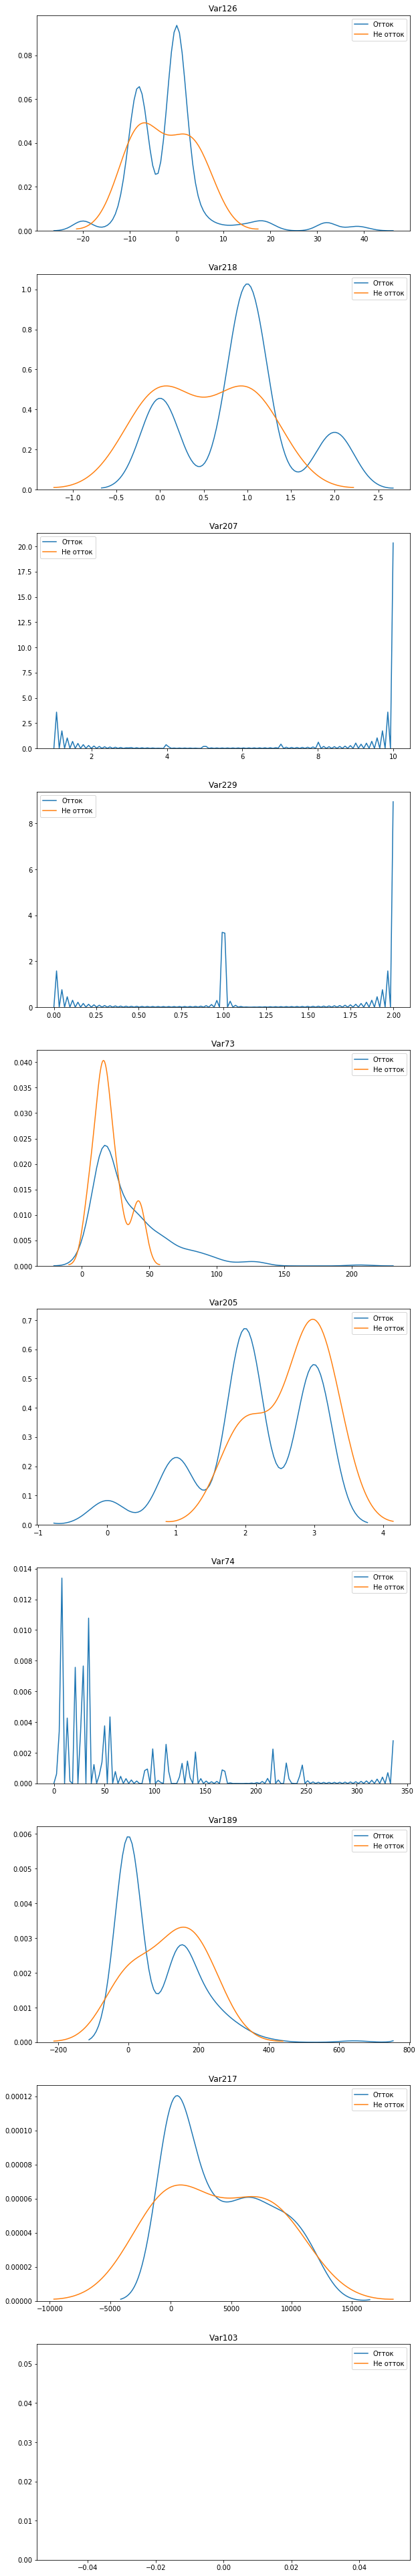

In [133]:
fig, ax = plt.subplots(nrows=10,ncols=1,figsize=(10,70))
for index, i in enumerate(importances_feats[:10].feature):
    a = sns.kdeplot(enc_data_1.iloc[first_type_err, :][(labels.iloc[first_type_err, :] == 1).values][i], 
                    ax = ax[index], label = 'Отток')
    a = sns.kdeplot(enc_data_1.iloc[second_type_err, :][(labels.iloc[second_type_err, :] == -1).values][i], 
                    ax = ax[index], label = 'Не отток')
    a.title.set_text(i)

In [124]:
importances_feats[:10].feature.values

array(['Var126', 'Var218', 'Var207', 'Var229', 'Var73', 'Var205', 'Var74',
       'Var189', 'Var217', 'Var103'], dtype=object)

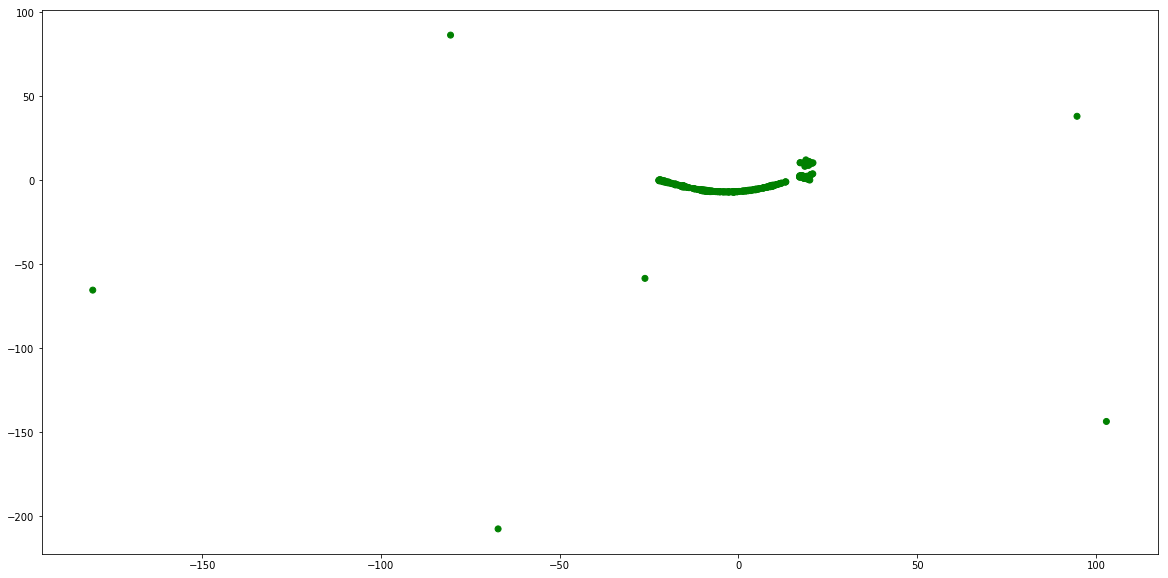

In [131]:
tsne = TSNE(random_state=100)
tsne_r = tsne.fit_transform(enc_data_1.iloc[first_type_err, :][importances_feats[:10].feature.values])
fig = plt.figure(figsize=(20,10))
plt.scatter(tsne_r[:, 0], tsne_r[:, 1], c=labels.iloc[first_type_err, :].labels.map({-1: 'blue', 1: 'green'}));
tsne_r = tsne.fit_transform(enc_data_1.iloc[second_type_err, :][importances_feats[:10].feature.values])
plt.scatter(tsne_r[:, 0], tsne_r[:, 1], c=labels.iloc[second_type_err, :].labels.map({1: 'blue', -1: 'green'}));

На визуализации видно, что объекты на которых совершена наибольшая ошибка похожи между собой. Объекты, на которых совершена ошибка второго рода, скорее всего, являются выбросами.

9\. По итогам проведенных экспериментов постройте финальную решение - модель с наилучшим качеством. Укажите, какие преобразования данных, параметры и пр. вы выбрали для построения финальной модели.

* На текущий момент определён следующий подход:
  * соотношение классов остаётся таким же, как в исходном наборе данных;
  * применяется LabeEncoder для категориальных признаков;
  * отбрасываются признаки со 100% пропусков и признаки с одним уникальным значением;
  * заполнение всех пропусков нулями.
  * Лучшие параметры для XGClassifier {'colsample_bytree': 1.0, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 90, 'reg_alpha': 0.2, 'reg_lambda': 1, 'subsample': 1.0}
  * финальная модель обучена на 50 самых важных признаках

In [0]:
train_1 = train.copy()

# заполнение пропусков нулями
train_1 = train_1.fillna(0)

# отбросим неинфомативные признаки
dropUninformativeFeatures(train_1)

# определение категориальных, численных признаков
num_f, cat_f, names_numf, names_cat_f = getNumCatFeats(train_1)

#кодирование категориальных признаков
enc_data_1 = LabelEnc(train_1, names_cat_f)

# отберём 50 важных признаков
data = enc_data_1.loc[:, importances_feats.feature.values[:50]]

Веса объектов класс отток 1.0  / класс не отток 1.0


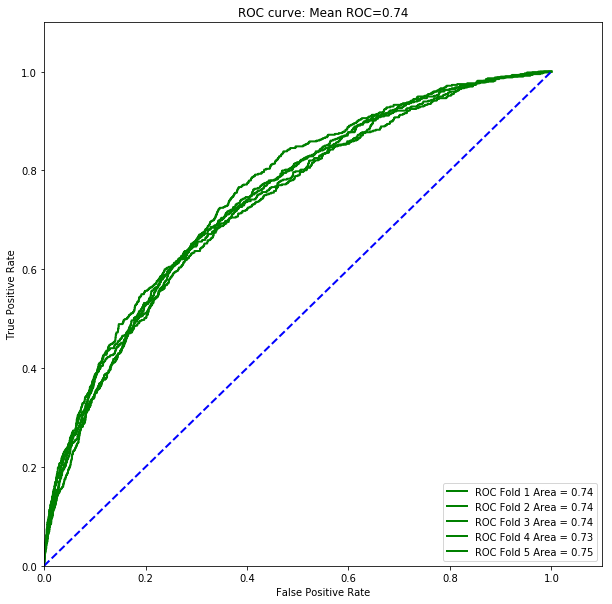

In [142]:
weights = {1: 1.0, -1: 1.0}
print('Веса объектов', f'класс отток {weights[1]}  /', f'класс не отток {weights[-1]}')
weights_for_model = np.array([weights[i] for i in labels.values.flatten()])

estimator = XGBClassifier(colsample_bytree = 1.0, max_depth = 4, 
                          min_child_weight = 1, n_estimators = 90,
                          reg_alpha = 0.2, reg_lambda = 1, subsample = 1.0)

y_scores, y_tests = KFold(estimator, data, labels, weights_for_model, n_folds = 5)
ROCCurve(y_tests, y_scores)

10\. Подумайте, можно ли еще улучшить модель? Что для этого можно сделать? 

Можно было бы удалить объекты-выбросы, потратить больше времени на оптимизацию параметров. Возможно бы помог такой подход как model stacking.